In [1]:
!pip install ipynb
!pip install nbimporter
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_curve, auc
import seaborn as sns
import plotly.express as px
sns.set(palette='rainbow', context='talk')
from sklearn.metrics import precision_recall_curve

import nbimporter
from EDA import vowelData
from EDA import irisData
from EDA import breastcancerData

# IRIS DATASET

In [2]:
df_, x ,y = irisData ()

## Apply OCC-SVM

In [3]:
target = 'target'
print("The dataset selected has shape: " + str(df_.shape) + " and for each class "+ str(Counter(df_[target])))

The dataset selected has shape: (150, 5) and for each class Counter({0: 50, 1: 50, 2: 50})


### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [4]:
df = df_.copy()
class_label = target

#Select the class you want to be outlier
out_class = 0
outliers_samples = df[df.target == out_class]

outliers_samples = outliers_samples.sample(frac = 0.2)

#concat in out
in_class = 1
inlier_samples = df[df.target == in_class]

# Concatenate the modified outliers samples with the original inlier samples
y = pd.concat([inlier_samples.target, outliers_samples.target], ignore_index=False).sort_index()
x = pd.concat([inlier_samples.drop(columns=class_label), outliers_samples.drop(columns=class_label)], ignore_index=False).sort_index()

Counter(y)

Counter({0: 10, 1: 50})

### Now we proceed with the OCC-SVM

In [5]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2468)

In [6]:
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the minority class and {sorted(Counter(y_train).items())[1][1]} records for the majority class.")

The number of records in the training dataset is 48
The number of records in the test dataset is 12
The training dataset has 8 records for the minority class and 40 records for the majority class.


In [7]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
ds1_f1 = []

for kernel in classical_kernels:
    # Train the one class support vector machine (SVM) model
    one_class_svm = OneClassSVM(nu=0.2, kernel = kernel, gamma = 'auto').fit(X_train)
    # Predict the anomalies
    prediction = one_class_svm.predict(X_test)
    prediction = [False if i==-1 else True for i in prediction]
    print("{} kernel classification f1 score is {}".format(kernel,f1_score(y_test, prediction)))
    ds1_f1.append(f1_score(y_test, prediction))

linear kernel classification f1 score is 0.9473684210526316
poly kernel classification f1 score is 0.9473684210526316
rbf kernel classification f1 score is 0.7777777777777777
sigmoid kernel classification f1 score is 0.0


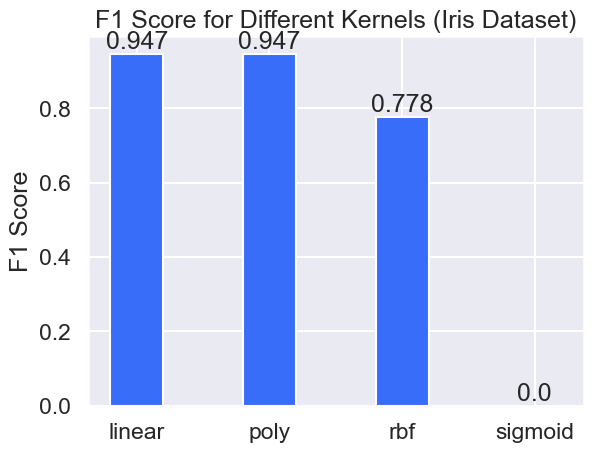

In [8]:
# Set the width of the bars
bar_width = 0.4

# Create a list of x positions for the bars
x_pos = range(len(classical_kernels))

# Create the bar plot
plt.bar(x_pos, ds1_f1, width=bar_width)

# Set the x-axis labels
plt.xticks(x_pos, classical_kernels)

# Set the y-axis label
plt.ylabel('F1 Score')

# Set the title of the graph
plt.title('F1 Score for Different Kernels (Iris Dataset)')

# Add the rounded values on top of each bar
for i, value in enumerate(ds1_f1):
    rounded_value = round(value, 3)  # Round off to three decimal points
    plt.text(i, value, str(rounded_value), ha='center', va='bottom')

# Show the plot
plt.show()

### Once we find the best performing kernal

In [9]:
one_class_svm = OneClassSVM(nu=0.2, kernel = 'poly', gamma = 'auto').fit(X_train)
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
prediction = [False if i==-1 else True for i in prediction]
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.90      0.95        10

    accuracy                           0.92        12
   macro avg       0.83      0.95      0.87        12
weighted avg       0.94      0.92      0.92        12



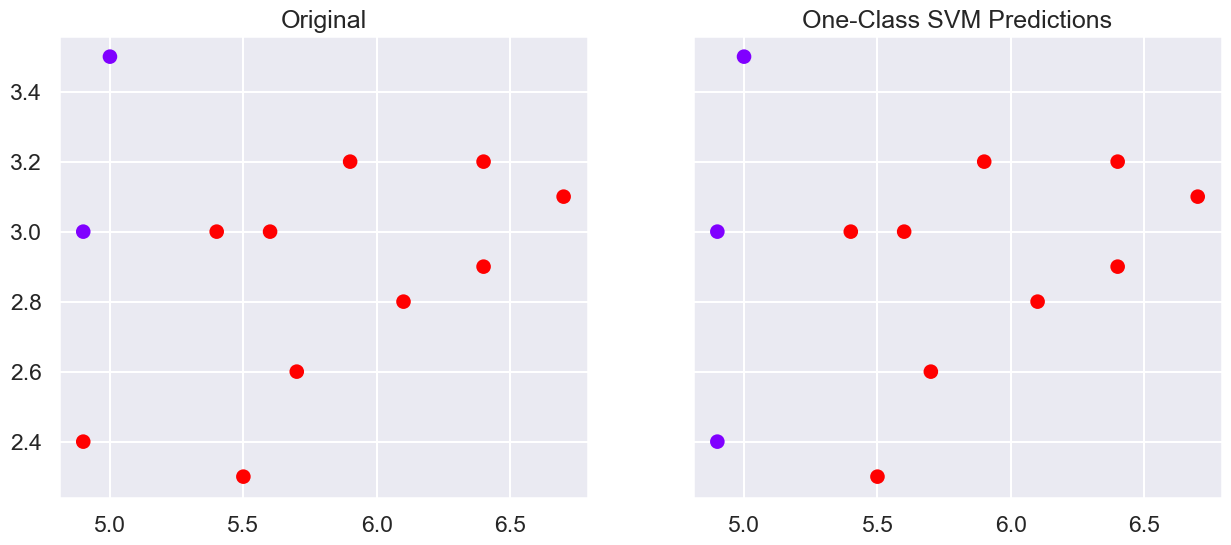

In [10]:
# Put the testing dataset and predictions in the same dataframe
X_test_ = X_test.copy()
y_test_ = y_test.copy()
df_test = pd.DataFrame(X_test_)
df_test['y_test'] = y_test_
df_test['one_class_svm_prediction'] = prediction
# Visualize the actual and predicted anomalies
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(15,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test[0], df_test[1], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test[0], df_test[1], c=df_test['one_class_svm_prediction'], cmap='rainbow')
plt.savefig('../figures/scatterplot_IRIS_SVM.png')

### Evaluation Metrics

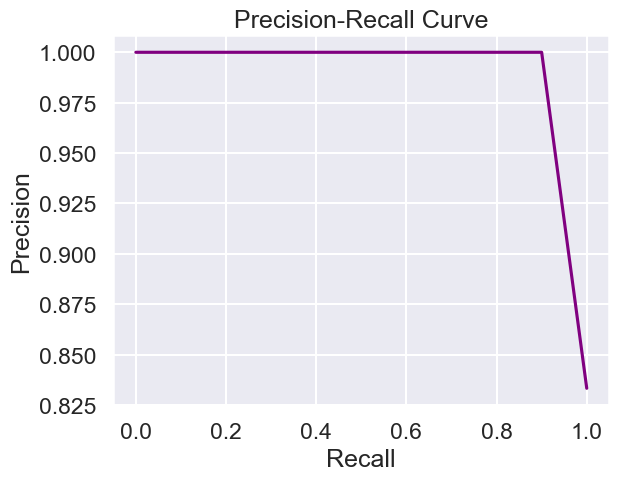

In [11]:
preds = one_class_svm.predict(X_test)
labels = y_test
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, preds)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
#plt.show()
plt.savefig('../figures/precisionCurve_IRIS_SVM.png')

### ROC-curve

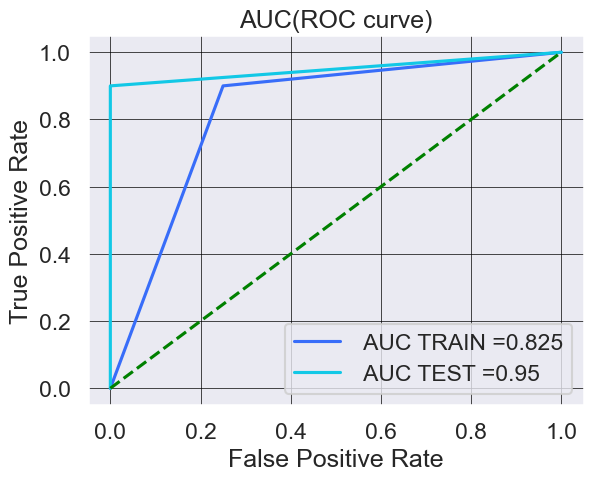

In [12]:
train_prediction = one_class_svm.predict(X_train)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, train_prediction)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
#plt.show()
plt.savefig('../figures/ROCCurve_IRIS_SVM.png')

# VOWEL DATASET

In [13]:
df_, x ,y = vowelData ()

## Apply OCC-SVM

In [14]:
#for vowels dataset
target = 'feature12'

print("The dataset selected has shape: " + str(df_.shape) + " and for each class "+ str(Counter(df_[target])))

The dataset selected has shape: (990, 13) and for each class Counter({0: 90, 1: 90, 2: 90, 3: 90, 4: 90, 5: 90, 6: 90, 7: 90, 8: 90, 9: 90, 10: 90})


### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [15]:
df = df_.copy()

#Select the class you want to be outlier
out_class = 0
outliers_samples = df[df.feature12 == out_class]

outliers_samples = outliers_samples.sample(frac = 0.2)

#concat in out
in_class = 1
inlier_samples = df[df.feature12 == in_class]

# Concatenate the modified outliers samples with the original inlier samples
y = pd.concat([inlier_samples.feature12, outliers_samples.feature12], ignore_index=False).sort_index()
x = pd.concat([inlier_samples.drop(columns='feature12'), outliers_samples.drop(columns='feature12')], ignore_index=False).sort_index()

Counter(y)

Counter({0: 18, 1: 90})

### Now we proceed with the OCC-SVM

In [16]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2468)

In [17]:
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the minority class and {sorted(Counter(y_train).items())[1][1]} records for the majority class.")

The number of records in the training dataset is 86
The number of records in the test dataset is 22
The training dataset has 17 records for the minority class and 69 records for the majority class.


In [18]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
ds1_f1 = []

for kernel in classical_kernels:
    # Train the one class support vector machine (SVM) model
    one_class_svm = OneClassSVM(nu=0.2, kernel = kernel, gamma = 'auto').fit(X_train)
    # Predict the anomalies
    prediction = one_class_svm.predict(X_test)
    prediction = [False if i==-1 else True for i in prediction]
    print("{} kernel classification f1 score is {}".format(kernel,f1_score(y_test, prediction)))
    ds1_f1.append(f1_score(y_test, prediction))

linear kernel classification f1 score is 0.8108108108108109
poly kernel classification f1 score is 0.742857142857143
rbf kernel classification f1 score is 0.975609756097561
sigmoid kernel classification f1 score is 0.8421052631578947


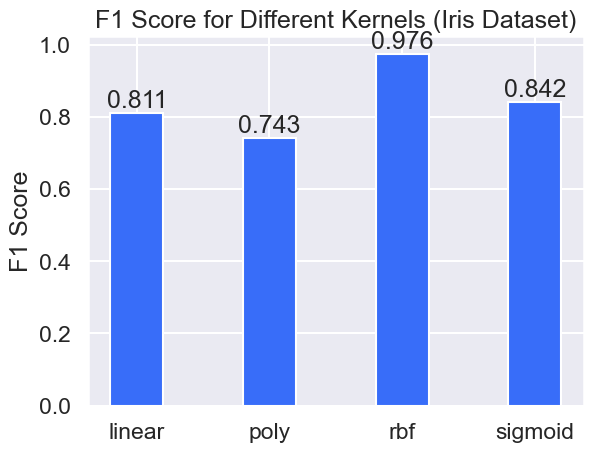

In [19]:
# Set the width of the bars
bar_width = 0.4

# Create a list of x positions for the bars
x_pos = range(len(classical_kernels))

# Create the bar plot
plt.bar(x_pos, ds1_f1, width=bar_width)

# Set the x-axis labels
plt.xticks(x_pos, classical_kernels)

# Set the y-axis label
plt.ylabel('F1 Score')

# Set the title of the graph
plt.title('F1 Score for Different Kernels (Iris Dataset)')

# Add the rounded values on top of each bar
for i, value in enumerate(ds1_f1):
    rounded_value = round(value, 3)  # Round off to three decimal points
    plt.text(i, value, str(rounded_value), ha='center', va='bottom')

# Show the plot
plt.show()

### Once we find the best performing kernal

In [20]:
one_class_svm = OneClassSVM(nu=0.2, kernel = 'rbf', gamma = 'auto').fit(X_train)
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
prediction = [False if i==-1 else True for i in prediction]
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.95      0.98        21

    accuracy                           0.95        22
   macro avg       0.75      0.98      0.82        22
weighted avg       0.98      0.95      0.96        22



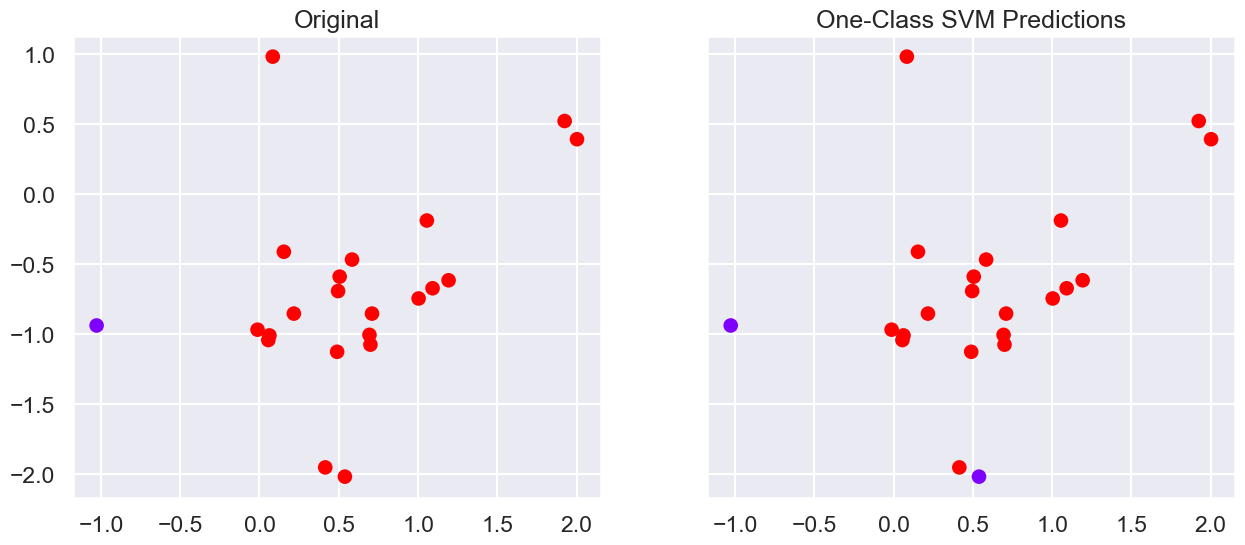

In [21]:
# Put the testing dataset and predictions in the same dataframe
X_test_ = X_test.copy()
y_test_ = y_test.copy()
df_test = pd.DataFrame(X_test_)
df_test['y_test'] = y_test_
df_test['one_class_svm_prediction'] = prediction
# Visualize the actual and predicted anomalies
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(15,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature3'], df_test['feature4'], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature3'], df_test['feature4'], c=df_test['one_class_svm_prediction'], cmap='rainbow')
plt.savefig('../figures/ScatterPlot_VOWEL_SVM.png')

### Evaluation Metrics

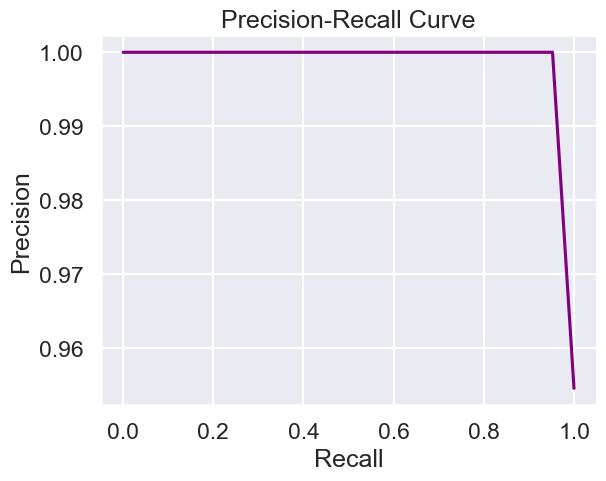

In [22]:
preds = one_class_svm.predict(X_test)
labels = y_test
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, preds)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
#plt.show()
plt.savefig('../figures/PrecisionCurve_VOWEL_SVM.png')

### ROC-curve

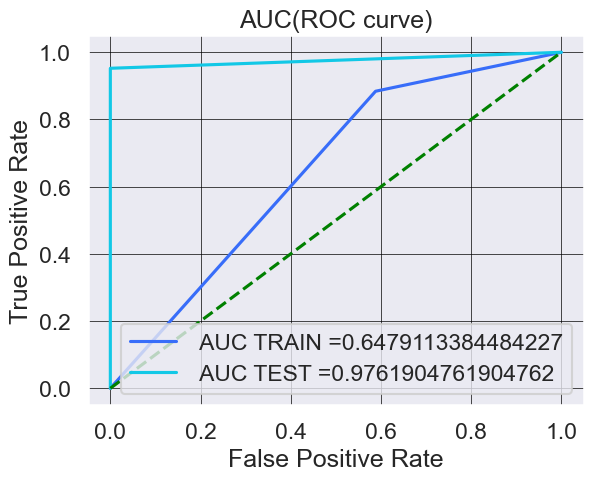

In [23]:
train_prediction = one_class_svm.predict(X_train)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, train_prediction)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
#plt.show()
plt.savefig('../figures/RocCurve_VOWEL_SVM.png')

# BREAST CANCER DATASET

In [24]:
df_, x ,y = breastcancerData()

## Apply OCC-SVM

In [25]:
target = 'target'

print("The dataset selected has shape: " + str(df_.shape) + " and for each class "+ str(Counter(df_[target])))

The dataset selected has shape: (569, 31) and for each class Counter({1: 357, 0: 212})


### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [26]:
df = df_.copy()
class_label = target

#Select the class you want to be outlier
out_class = 0
outliers_samples = df[df.target == out_class]

outliers_samples = outliers_samples.sample(frac = 0.2)

#concat in out
in_class = 1
inlier_samples = df[df.target == in_class]

# Concatenate the modified outliers samples with the original inlier samples
y = pd.concat([inlier_samples.target, outliers_samples.target], ignore_index=False).sort_index()
x = pd.concat([inlier_samples.drop(columns=class_label), outliers_samples.drop(columns=class_label)], ignore_index=False).sort_index()

Counter(y)

Counter({0: 42, 1: 357})

### Now we proceed with the OCC-SVM

In [27]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2468)

In [28]:
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the minority class and {sorted(Counter(y_train).items())[1][1]} records for the majority class.")

The number of records in the training dataset is 319
The number of records in the test dataset is 80
The training dataset has 30 records for the minority class and 289 records for the majority class.


In [29]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
ds1_f1 = []

for kernel in classical_kernels:
    # Train the one class support vector machine (SVM) model
    one_class_svm = OneClassSVM(nu=0.2, kernel = kernel, gamma = 'auto').fit(X_train)
    # Predict the anomalies
    prediction = one_class_svm.predict(X_test)
    prediction = [False if i==-1 else True for i in prediction]
    print("{} kernel classification f1 score is {}".format(kernel,f1_score(y_test, prediction)))
    ds1_f1.append(f1_score(y_test, prediction))

linear kernel classification f1 score is 0.7969924812030074
poly kernel classification f1 score is 0.7969924812030074
rbf kernel classification f1 score is 0.0
sigmoid kernel classification f1 score is 0.0


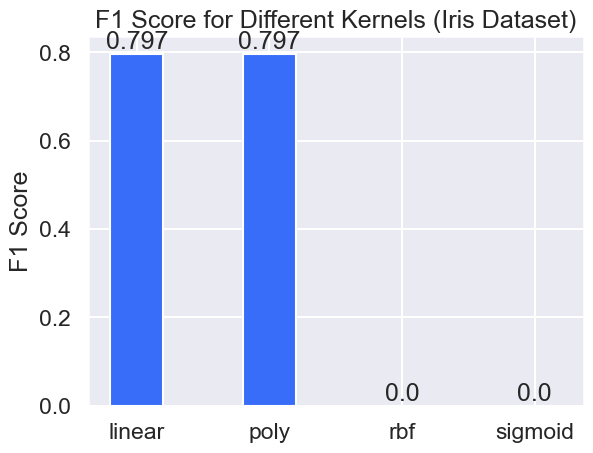

In [30]:
# Set the width of the bars
bar_width = 0.4

# Create a list of x positions for the bars
x_pos = range(len(classical_kernels))

# Create the bar plot
plt.bar(x_pos, ds1_f1, width=bar_width)

# Set the x-axis labels
plt.xticks(x_pos, classical_kernels)

# Set the y-axis label
plt.ylabel('F1 Score')

# Set the title of the graph
plt.title('F1 Score for Different Kernels (Iris Dataset)')

# Add the rounded values on top of each bar
for i, value in enumerate(ds1_f1):
    rounded_value = round(value, 3)  # Round off to three decimal points
    plt.text(i, value, str(rounded_value), ha='center', va='bottom')

# Show the plot
plt.show()

### Once we find the best performing kernal

In [31]:
one_class_svm = OneClassSVM(nu=0.2, kernel = 'poly', gamma = 'auto').fit(X_train)
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
prediction = [False if i==-1 else True for i in prediction]
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.82      0.78      0.80        68

    accuracy                           0.66        80
   macro avg       0.41      0.39      0.40        80
weighted avg       0.69      0.66      0.68        80



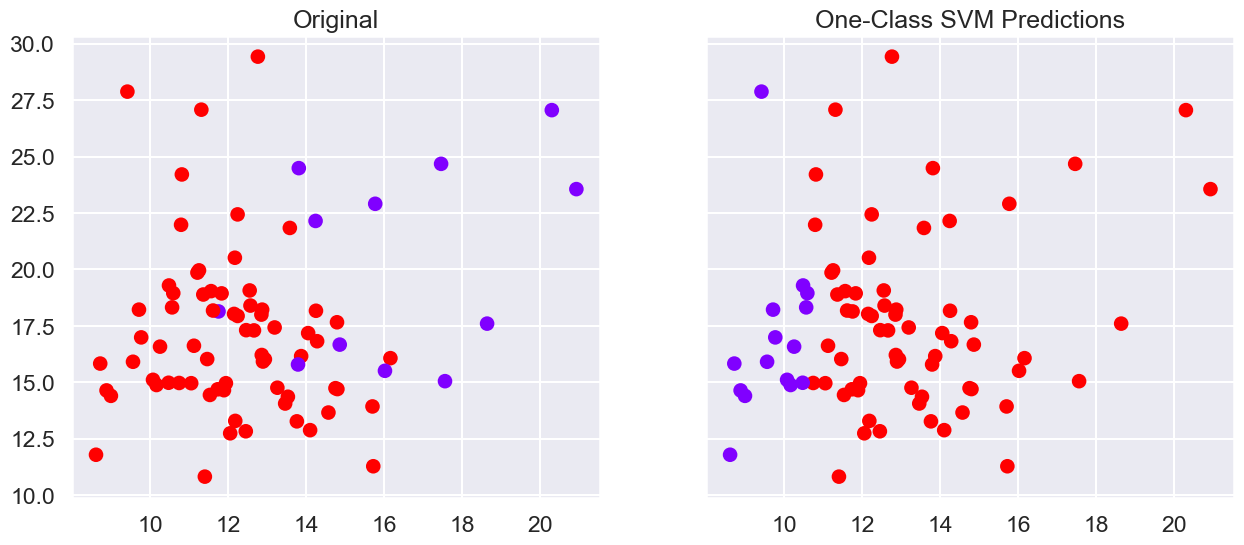

In [32]:
# Put the testing dataset and predictions in the same dataframe
X_test_ = X_test.copy()
y_test_ = y_test.copy()
df_test = pd.DataFrame(X_test_)
df_test['y_test'] = y_test_
df_test['one_class_svm_prediction'] = prediction
# Visualize the actual and predicted anomalies
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(15,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test[0], df_test[1], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test[0], df_test[1], c=df_test['one_class_svm_prediction'], cmap='rainbow')
plt.savefig('../figures/Scatterplot_BREAST_SVM.png')

### Evaluation Metrics

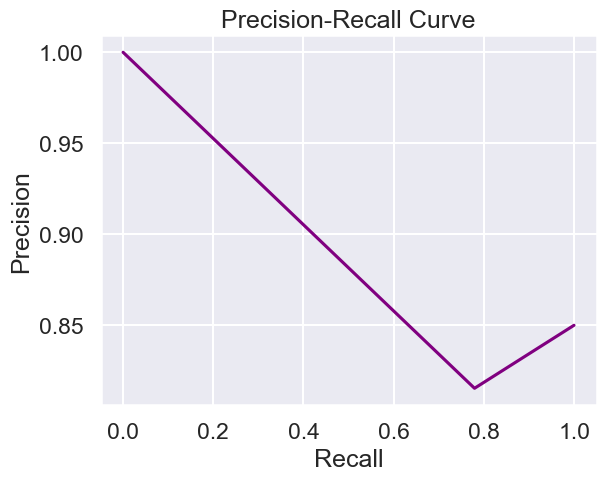

In [33]:
preds = one_class_svm.predict(X_test)
labels = y_test
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, preds)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
#plt.show()
plt.savefig('../figures/PrecisionCurve_BREAST_SVM.png')

### ROC-curve

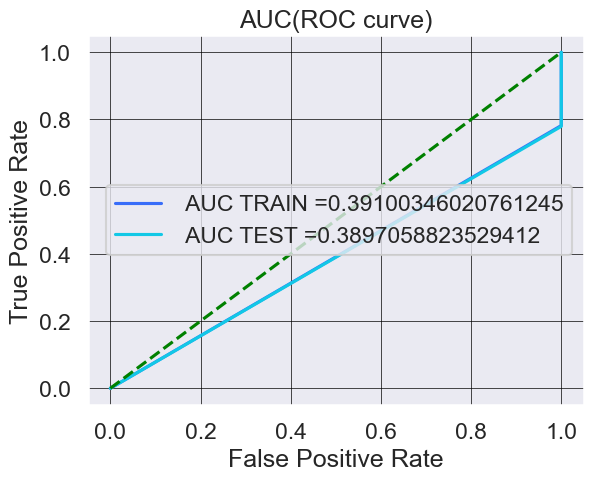

In [34]:
train_prediction = one_class_svm.predict(X_train)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, train_prediction)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
#plt.show()
plt.savefig('../figures/ROCCurve_BREAST_SVM.png')